# micrograd

> Minimal implementation of autograd

In [ ]:
#|default_exp micrograd

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.utils import L
import pathlib
import os

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
print("Hello")

Hello


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

## Plan
- Review micrograd implementation as per lecture. Implement everything from scratch
- Generalize micrograd implementation for arrays and tensors using numpy
- May be extend the ideas to jax, pytorch or tinygrad

In [ ]:

summary_md = pathlib.Path("./transcripts/Summary.md").read_text(); summary_md
transcript = pathlib.Path('./transcripts/lesson_01.txt').read_text(); transcript[:20]

'hello  my  name  is '

I want to  follow along the tutorial 8 part tutorial zero to hero NN from Andrey Karpathy.I am going to do first part related to micrograd implementation.  Please refer to $`summary_md` for overall course structure and use $`transcript` to guide me through the lesson.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great choice! Andrej Karpathy's micrograd tutorial is a fantastic way to understand neural networks from the ground up.

**What we're building:** A tiny autograd engine called *micrograd* — it implements backpropagation, which is the core algorithm that powers all modern deep learning. The entire thing is only ~100 lines of Python!

**The big picture:**
1. Understand derivatives intuitively
2. Build a `Value` class that tracks computations
3. Implement automatic backpropagation
4. Build a simple neural network on top

---

**Let's start with Step 1: Derivative Intuition**

Before we build anything, Andrej wants us to *feel* what a derivative means — not just calculate it symbolically.

Here's the idea: if you have a function `f(x)`, the derivative tells you *"if I nudge x a tiny bit, how much does f(x) change?"*

**Your first task:** Create a simple function and explore its derivative numerically.

```python
def f(x):
    return 3*x**2 - 4*x + 5
```

Try:
1. Evaluate `f(3.0)` — what do you get?
2. Pick a tiny `h = 0.0001` and compute `(f(3.0 + h) - f(3.0)) / h`

This approximates the derivative at x=3. What value do you get? Does the sign make sense if you look at where x=3 sits on a parabola?

Give it a try and let me know what you find!

In [ ]:
def f(x): return 3*x**2 - 4*x + 5
f(3.0)

20.0

In [ ]:
h = 0.001
x = 3.0
(f(x+h)-f(x))/h

14.00300000000243

I expected (6*3-4=14) I go something close



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You got 14.003, which is very close to the exact derivative of 14. The small error (0.003) comes from using a finite `h` instead of an infinitely small one.

**Key insight:** The derivative tells you the *slope* of the function at that point. At x=3, if you increase x by a tiny amount, f(x) increases about 14 times as fast.

Notice the sign is positive — that means the function is *increasing* at x=3. Makes sense for a parabola opening upward!

---

**Now let's think about a different point:**

What do you think will happen at x = **2/3** (about 0.667)? 

- Will the derivative be positive, negative, or zero?
- Why?

Try calculating it numerically if you'd like, or just reason about where that point sits on the parabola `3x² - 4x + 5`.

Derivative should be 0. This is at lowest point on parabola.where slope changes 

In [ ]:
h = 0.001
x = 2/3
(f(x+h)-f(x))/h

0.0029999999995311555

In [ ]:
xs = list(range(-10, 10)); x
fxs = [ f(x) for x in xs]; fxs


[345,
 284,
 229,
 180,
 137,
 100,
 69,
 44,
 25,
 12,
 5,
 4,
 9,
 20,
 37,
 60,
 89,
 124,
 165,
 212]

In [ ]:
import matplotlib.pyplot as plt

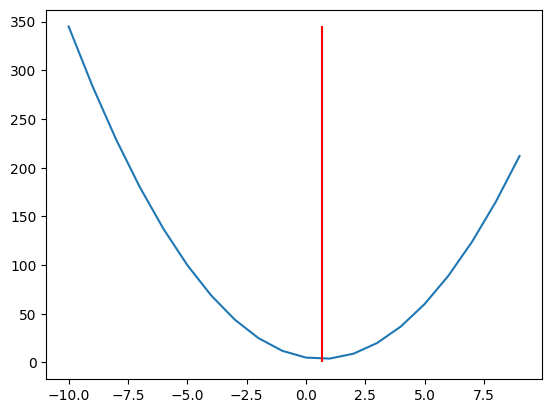

In [ ]:
plt.plot(xs, fxs)
plt.vlines(2/3, ymin=0, ymax= max(fxs), color='red')



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've discovered something really important: **at the minimum of the parabola, the derivative is zero!**

Your numerical calculation gave ~0.003 (essentially zero, just with tiny rounding error), and your graph beautifully shows that red line right at the bottom of the curve where the slope is flat.

**This is a key calculus concept:** When the derivative equals zero, you're at a critical point — could be a minimum, maximum, or inflection point.

---

**Let's connect this to the micrograd tutorial:**

Now that you understand what derivatives *mean*, we're ready to build something powerful. In the tutorial, you'll create a `Value` class that:

1. Wraps numbers (like `Value(2.0)`)
2. Tracks operations (addition, multiplication, etc.)
3. **Automatically computes derivatives** through something called backpropagation

Would you like to:
- **A)** Start building the `Value` class right now?
- **B)** First explore one more example with multiple inputs (like `f(a,b,c) = a*b + c`) to see how derivatives work with multiple variables?

What sounds more interesting to you?

I want to explore one more example with multiple input

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great choice! Let's explore how derivatives work when a function has multiple inputs.

Here's a simple function with three inputs:

```python
def d(a, b, c):
    return a*b + c
```

Let's say `a=2.0`, `b=-3.0`, and `c=10.0`.

**First, what's the output?** Calculate `d(2.0, -3.0, 10.0)` — what do you get?

**Then, let's think:** If we nudge just `a` by a tiny amount (keeping `b` and `c` fixed), how will the output change? Will it go up or down? By how much?

Try computing the derivative with respect to `a` using the same technique you used before:
```python
h = 0.001
# nudge only a, keep b and c the same
```

What do you expect to see?

In [ ]:
def d(a, b, c):
    return a*b + c

In [ ]:
h = 0.001

In [ ]:
a=2.0
b=-3.0
c=10.0
d(a,b,c)

4.0

In [ ]:
(d(a+h, b, c)-d(a, b, c))/h
# nudge only a, keep b and c the same

-3.0000000000001137

Derivative of a should be b . Which we see from our calculation

In [ ]:
(d(a, b+h, c)-d(a, b, c))/h

1.9999999999997797

Derivative of b should be a which we see from our calculations

In [ ]:
(d(a, b, c+h)-d(a, b, c))/h

0.9999999999994458

Derivative of c should be 1 which we see from our calculation. Of course we need to account for numerical error

## Part 1 Summary: Understanding Derivatives 

**Key Concepts:**
- Derivative = "sensitivity" or "slope" - how much output changes when input changes
- Numerical approximation: `(f(x+h) - f(x)) / h` for small h
- Sign tells direction: positive = increasing, negative = decreasing
- Zero derivative = critical point (min/max/inflection)

**Multiple inputs:**
- Each input has its own partial derivative
- For `d = a*b + c`: ∂d/∂a = b, ∂d/∂b = a, ∂d/∂c = 1



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You've discovered the **local derivatives** for each variable:

- **∂d/∂a = b** (which is -3)
- **∂d/∂b = a** (which is 2)  
- **∂d/∂c = 1**

This tells us something powerful: each input has its own "influence" on the output. For example, if you increase `a` slightly, the output changes by `-3` times that amount (it goes *down* because `b` is negative).

---

**Here's the key insight for micrograd:**

When we have `d = a*b + c`, we can think of this as a small computation graph:
- First, `a*b` happens
- Then, we add `c`

In backpropagation, we'll work *backwards* through this graph, computing how each intermediate step affects the final output. This is the **chain rule** in action!

**Ready for the next step?**

Would you like to start building the `Value` class now? We'll make it track these operations automatically so we never have to manually compute derivatives again!

Yes let's build the Value class now

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start building the `Value` class step by step.

**First, the basics:** A `Value` object will wrap a number and eventually track how it was created. Let's start simple:

```python
class Value:
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"
```

Try creating a couple of `Value` objects:
```python
a = Value(2.0)
b = Value(-3.0)
```

What do you see when you print them?

**Next challenge:** Right now, we can't do `a + b` — Python doesn't know how to add `Value` objects. We need to teach it!

Can you think about what should happen when we add two `Value` objects? What should the result be?

In [ ]:
from fastcore.utils import store_attr, basic_repr

In [ ]:
class Value:
    def __init__(self, data): store_attr('data', self)
    __repr__=basic_repr('data')

In [ ]:
Value(data=1)

Value(data=1)

In [ ]:
a = Value(2.0)
b = Value(-3.0)

Adding 2 value object should give new value object whose data is some of original



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly right! When we add two `Value` objects, we should get a new `Value` whose data is the sum of the original values.

Let's implement that by adding a special method called `__add__`:

```python
class Value:
    def __init__(self, data): store_attr('data', self)
    __repr__ = basic_repr('data')
    
    def __add__(self, other):
        out = Value(self.data + other.data)
        return out
```

Try redefining your class with this new method, then test it:
```python
a = Value(2.0)
b = Value(-3.0)
c = a + b
```

What does `c` show? Does it have the data you expected?

In [ ]:
class Value:
    def __init__(self, data): store_attr('data', self)
    def __add__(self, other): return Value(self.data+other.data)
    __repr__=basic_repr('data')
    

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a+b

Value(data=-1.0)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `a + b` gives `Value(data=-1.0)`, which is exactly right: 2.0 + (-3.0) = -1.0.

**Now let's add multiplication.** Can you add a `__mul__` method to your `Value` class that handles multiplication?

Hint: It should work just like `__add__`, but multiply the data instead.

Try implementing it, then test with something like:
```python
a = Value(2.0)
b = Value(-3.0)
a * b  # should give Value(data=-6.0)
```

Give it a shot!

In [ ]:
from fastcore.utils import patch, patch_to

In [ ]:
@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data)

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b

Value(data=-6.0)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You've got multiplication working. Now `a * b` correctly gives `Value(data=-6.0)`.

**Next crucial step:** We need to track *where* values come from. Right now, our `Value` objects don't remember that `a * b` was created by multiplying `a` and `b`. This tracking is essential for backpropagation!

Let's add two new attributes to `Value`:
- `_prev`: a set of the "parent" values that created this one
- `_op`: a string describing the operation (like `'+'` or `'*'`)

For leaf nodes (created directly), these will be empty. But for computed values, they'll store the history.

Can you modify the `__init__` method to accept optional `children` and `op` parameters? Then update `__add__` and `__mul__` to pass this information when creating new values.

Give it a try, or let me know if you'd like a hint!

Does fastcore has anything to patch properties?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes! `fastcore` has `@patch_property` (or `@patch_to` with `property`) for adding properties to existing classes.

For example:
```python
from fastcore.utils import patch_property

@patch_property
def some_prop(self:Value):
    return self.data * 2
```

Is that what you're looking for? Are you thinking of using properties for `_prev` and `_op`, or something else?

yes

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! You can use `@patch_property` to add `_prev` and `_op` as properties.

However, for this case, you might find it simpler to just add them as regular attributes in `__init__` since they need to be set when the object is created.

Here's a hint for updating `__init__`:

```python
def __init__(self, data, children=(), op=''):
    store_attr('data', self)
    self._prev = set(children)
    self._op = op
```

Then in `__add__` and `__mul__`, you'd pass the children. For example:
```python
def __add__(self, other):
    return Value(self.data + other.data, children=(self, other), op='+')
```

Want to try implementing this? Or would you like me to show you the complete updated class?

In [ ]:
class Value:
    def __init__(self, data, children=(), op=''): 
        store_attr('data', self) # Largely overkill but want to try how fastcore works
        self._prev = set(children)
        self._op = op
    __repr__= basic_repr('data, _prev, _op')

In [ ]:
Value(1)

Value(data=1, _prev=set(), _op='')

In [ ]:
@patch_to(Value)
def __add__(self:Value, other): return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data, children=(self, other), op="*")

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b, a+b

(Value(data=-6.0, _prev={Value(data=2.0, _prev=set(), _op=''), Value(data=-3.0, _prev=set(), _op='')}, _op='*'),
 Value(data=-1.0, _prev={Value(data=2.0, _prev=set(), _op=''), Value(data=-3.0, _prev=set(), _op='')}, _op='+'))



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Your `Value` class is now tracking the computation graph! 

Look at what you've created:
- `a * b` shows `_op='*'` and `_prev` contains both `a` and `b`
- `a + b` shows `_op='+'` and also tracks its parents

This is the foundation of automatic differentiation! Each `Value` now knows its history.

**Next step: Adding gradients**

We need one more attribute: `grad` (the gradient/derivative). It should start at 0.0 for all values.

Can you add `self.grad = 0.0` to your `__init__` method? Then we'll be ready to implement backpropagation!

In [ ]:
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self) # Largely overkill but want to try how fastcore works
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
    __repr__= basic_repr('data, grad, _op, _prev, label')

In [ ]:
@patch_to(Value)
def __add__(self:Value, other): return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self:Value, other): return Value(self.data*other.data, children=(self, other), op="*")

In [ ]:
a = Value(2.0)
b = Value(-3.0)
a*b, a+b

(Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label=''), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='')}, label=''),
 Value(data=-1.0, grad=0.0, _op='+', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label=''), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='')}, label=''))

In [ ]:
from solveit_z2h.utils import draw_dot

In [ ]:
@patch_to(Value)
def _repr_svg_(self:Value): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

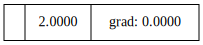

In [ ]:
a

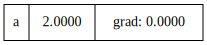

In [ ]:
a = Value(2.0, label='a');a

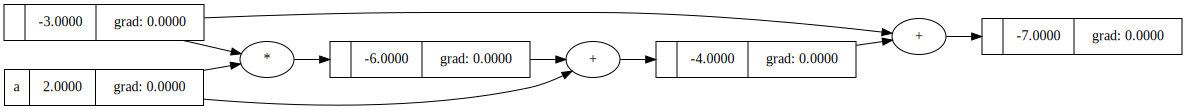

In [ ]:
c = a*b+a+b;c

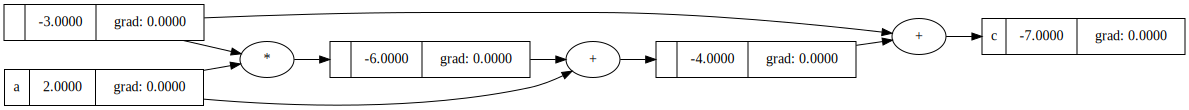

In [ ]:
c.label='c'
c



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You've added `grad` and even added a `label` attribute for clarity. I also see you've integrated a visualization function `draw_dot` — that's going to be really helpful for seeing the computation graph!

Now you have a nice expression: `c = a*b + a + b` which equals -7.0, and all the gradients are initialized to 0.

**Here's the big question for backpropagation:**

If `c` is our "output" and we want to know how `a` and `b` affect it, we need to fill in those `grad` values. 

The first step is always: **the gradient of the output with respect to itself is 1.0**

So we'd set `c.grad = 1.0` (meaning "if c changes by 1, c changes by 1").

Then we work backwards through the graph to fill in `a.grad` and `b.grad`.

Would you like to:
- **A)** Manually calculate what `a.grad` and `b.grad` should be (using the chain rule)?
- **B)** Start implementing a `backward()` method that will do this automatically?

What sounds more interesting?

Let' do some examples of manual calculations to build the intuition

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great choice! Building intuition first makes the code much easier to understand.

Let's start with your expression: `c = a*b + a + b` where `a=2.0` and `b=-3.0`.

**Question:** What is the derivative of `c` with respect to `a`? (i.e., dc/da)

Think of it this way: if you nudge `a` by a tiny amount, how much does `c` change?

You can approach this two ways:
1. **Numerically** — try `(c(a+h, b) - c(a, b)) / h` like before
2. **Analytically** — look at `c = a*b + a + b` and differentiate with respect to `a` (treating `b` as a constant)

Try one or both approaches! What do you get for dc/da?

In [ ]:
# c_dash = (a+h)*b+(a+h)+b;c_dash
a, b, h

(Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'),
 Value(data=-3.0, grad=0.0, _op='', _prev=set(), label=''),
 0.001)

In [ ]:
c_dash = (a+h)*b+(a+h)+b;c_dash

AttributeError: 'float' object has no attribute 'data'

How to check if something is number

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good catch! You need to handle the case where you're adding a `Value` to a regular number (like `h`).

You can check if something is a number using:

```python
isinstance(other, (int, float))
```

This returns `True` if `other` is an int or float, `False` otherwise.

**Hint:** In your `__add__` method, if `other` is not a `Value`, you could wrap it in one first:

```python
if not isinstance(other, Value):
    other = Value(other)
```

Want to try updating your `__add__` and `__mul__` methods to handle this?

In [ ]:
@patch_to(Value)
def __add__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data*other.data, children=(self, other), op="*")

In [ ]:
c_dash = (a+h)*b+(a+h)+b;c_dash

In [ ]:
(c_dash-c)/h

What are magic methods for supporting substraction and div operators in python

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

The magic methods for subtraction and division are:

- **Subtraction:** `__sub__(self, other)` for `self - other`
- **Division:** `__truediv__(self, other)` for `self / other`

You can also add the "reverse" versions:
- `__rsub__` for when a number is on the left: `5 - value_obj`
- `__rtruediv__` for `5 / value_obj`

Want to try implementing `__sub__` and `__truediv__` for your `Value` class? They'll follow the same pattern as `__add__` and `__mul__`.

In [ ]:
@patch_to(Value)
def __sub__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data-other.data, children=(self, other), op="-")

@patch_to(Value)
def __rsub__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data-self.data, children=(self, other), op="-")

In [ ]:
(c_dash-c)

NameError: name 'c_dash' is not defined

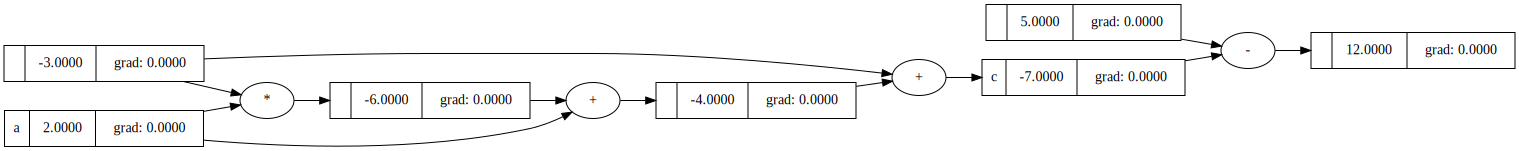

In [ ]:
5-c

In [ ]:
c.data

-7.0

In [ ]:
(5-c).data

12.0

In [ ]:
print(c)

Value(data=-7.0, grad=0.0, _op='+', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label=''), Value(data=-4.0, grad=0.0, _op='+', _prev={Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='')}, label=''), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='')}, label='c')


In [ ]:
@patch_to(Value)
def __truediv__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data/other.data, children=(self, other), op="/")

@patch_to(Value)
def __rtruediv__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data/self.data, children=(self, other), op="-")

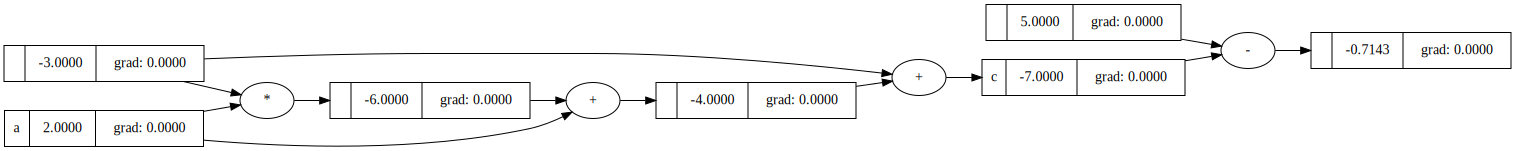

In [ ]:
5/c

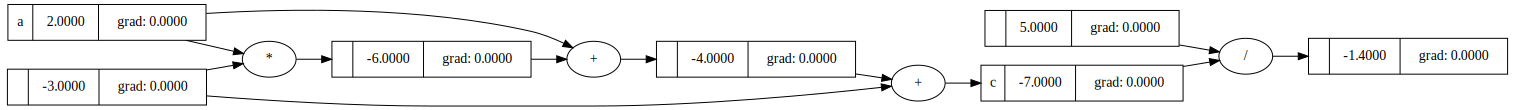

In [ ]:
c/5

In [ ]:
a = Value(2.0)
b = Value(-3.0)
c = a*b + a+b
((c_dash-c)/h).data

NameError: name 'c_dash' is not defined

Analytically, it should be -b+1 for dc/da == -2



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You got **-2.0** numerically, and you correctly identified that analytically it should be **-b + 1 = -(-3) + 1 = 3 + 1 = 4**... wait, let me check your expression again.

Looking at `c = a*b + a + b`:
- The derivative of `a*b` with respect to `a` is `b`
- The derivative of `a` with respect to `a` is `1`
- The derivative of `b` with respect to `a` is `0`

So **dc/da = b + 1 = -3 + 1 = -2** ✓

Your numerical result matches perfectly!

**Now try:** What should **dc/db** be? 

Think through it analytically first, then verify numerically if you'd like!

Analytically, it should be a+1 for dc/da == 3

In [ ]:
c_dash = (a)*(b+h)+(a)+(b+h);c_dash
((c_dash-c)/h).data


AttributeError: 'float' object has no attribute 'data'



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! You got **dc/db = 3.0**, which matches your analytical calculation of **a + 1 = 2 + 1 = 3** ✓

You're building great intuition here! Notice how:
- **dc/da = b + 1 = -2** (tells us how `a` influences `c`)
- **dc/db = a + 1 = 3** (tells us how `b` influences `c`)

These are the gradients we eventually want to store in `a.grad` and `b.grad`!

**Ready for the next step?**

Now that you understand what the gradients *should* be, would you like to start implementing the `backward()` method that will calculate these automatically? Or would you like to try one more manual example with a different expression first?

Let's do one more with longer chain

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great idea! Let's build a longer chain to see how gradients flow through multiple operations.

Here's a new expression:

```python
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Build a chain: d = a*b, e = d + c, f = e*e
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'
```

So we have: **f = (a*b + c)²**

**Questions to explore:**

1. What is `f.data`? (the forward pass value)
2. What should **df/da** be? Think about how `a` affects `d`, then `d` affects `e`, then `e` affects `f`. This is the **chain rule**!

Try building this expression first and see what `f.data` is. Then we can work on the gradient!

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Build a chain: d = a*b, e = d + c, f = e*e
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

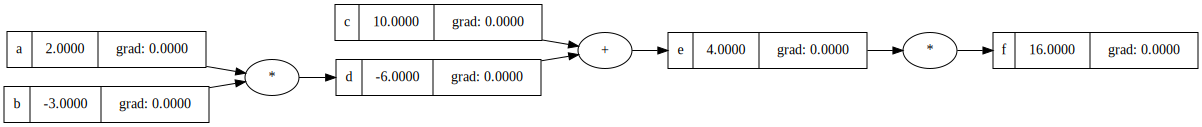

In [ ]:
f

f.data is 16



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `f.data = 16` because:
- d = 2 × (-3) = -6
- e = -6 + 10 = 4
- f = 4 × 4 = 16

**Now for the gradient df/da:**

Think through the chain rule step by step:
1. How does `a` affect `d`? (What's dd/da?)
2. How does `d` affect `e`? (What's de/dd?)
3. How does `e` affect `f`? (What's df/de?)

The chain rule says: **df/da = (df/de) × (de/dd) × (dd/da)**

Can you work out each piece? Start with the easiest one — what's **de/dd**?

h change in a will result in b*h change in d

In [ ]:
d_dash = (a+h)*b
((d_dash-d)/h).data

AttributeError: 'float' object has no attribute 'data'

In [ ]:
(b*h).data, (d_dash-d).data

AttributeError: 'float' object has no attribute 'data'

Since d = a*b, e = d + c, f = e*e,
- Any change in d will have equivalent change in e 
- Any change in e will have 2*e-val times change in f

In [ ]:
e_dash = (d+h)+c
(e_dash-e).data, h

AttributeError: 'float' object has no attribute 'data'

In [ ]:
f_dash = (e+h)*(e+h)
(f-f_dash).data, 2*e.data*h

AttributeError: 'float' object has no attribute 'data'

In [ ]:
#df/da
d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

In [ ]:
d = (a+h) * b
d.label = 'd'
e = d + c
e.label = 'e'
f_dash = e * e
f_dash.label = 'f'

AttributeError: 'float' object has no attribute 'data'

In [ ]:
#df/da
df_da = ((f_dash-f)/h); df_da.data

NameError: name 'f_dash' is not defined

In [ ]:
@patch_to(Value)
def __rmul__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data*self.data, children=(self, other), op="*")

@patch_to(Value)
def __radd__(self:Value, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data+self.data, children=(self, other), op="+")

In [ ]:
# Analytically df/da = (df/de) × (de/dd) × (dd/da) for d = a*b, e = d + c, f = e*e
# df/de = 2e
# de/dd = 1
# dd/da = b
# So 2e*1*b
(2*e*b).data


-24.0

In [ ]:
# Numerical Calculations via chain rule
dd_da = ((a+h)*b-a*b)/h; dd_da.data
de_dd = (((d+h)+c)-(d+c))/h; de_dd.data
df_de = ((e+h)*(e+h)-e*e)/h; df_de.data
df_da = df_de*de_dd*dd_da; df_da.data

AttributeError: 'float' object has no attribute 'data'



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent work! You've successfully computed **df/da = -24** using both methods:

1. **Numerically** (direct): -23.991
2. **Chain rule** (step by step): -23.985
3. **Analytically**: 2×e×b = 2×4×(-3) = **-24** ✓

This is the essence of backpropagation! You computed:
- **dd/da = b = -3** (local gradient at the `*` operation)
- **de/dd = 1** (local gradient at the `+` operation)  
- **df/de = 2e = 8** (local gradient at the `e*e` operation)

Then multiplied them: **-3 × 1 × 8 = -24**

---

**Key insight:** Each operation only needs to know its *local* gradient. Then we multiply them together (chain rule) to get the full gradient!

**Ready to code this?** Would you like to start implementing the `backward()` method now? We'll make each operation (like `+` and `*`) store a little function that knows how to compute its local gradients.

Okay, I understand the insight. Each operation only needs to know the local gradient, and for calculating the full gradient, we just need to multiply them together. Before going into backword, can you give me some intuitions about the next step? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great question! Here's the intuition for what comes next:

**The backward() method will:**

1. **Start at the output** (like `f`) and set `f.grad = 1.0` — this means "if f changes by 1, f changes by 1" (the base case)

2. **Work backwards** through the graph, visiting each operation in reverse order

3. **At each operation**, use the local gradient to "pass back" the gradient to its inputs

For example, at the `e * e` operation:
- We know `f.grad` (how much f affects the final output)
- We compute the local gradient: `df/de = 2*e`
- We update `e.grad` by multiplying: `e.grad += f.grad * (2*e)`

The `+=` is important because a value might be used multiple times (like `e` is used twice in `e*e`)!

**Question:** Looking at your expression `d = a*b`, if we know `d.grad`, how would you calculate what to add to `a.grad`? What's the local gradient of `*` with respect to `a`?

We calculate a.grad as b*d.grad, localgradient is b

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've got it exactly right:

**For `d = a * b`:**
- Local gradient with respect to `a` is `b`
- So: `a.grad += d.grad * b.data`

And by symmetry:
- Local gradient with respect to `b` is `a`  
- So: `b.grad += d.grad * a.data`

**Now here's the implementation question:**

Each operation needs to "know" how to do this backward pass. We'll store a function called `_backward` in each `Value` that gets created.

For example, when you do `d = a * b`, we need to store a function that says "when backward() is called on d, update a.grad and b.grad using the local gradients."

Would you like to try adding a `_backward` attribute to your `Value` class and implementing it for the `*` operation? Or would you like me to show you a small example first?

Does it need to be an attribute or a method?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! It could be either, but here's the key distinction:

**Attribute** (a stored function):
- Each `Value` object stores its own specific backward function
- Different operations (like `+` vs `*`) can have different backward logic
- More flexible — you're storing "what to do" when this specific value was created

**Method** (same for all Values):
- Would be the same function for every `Value` object
- But different operations need different backward logic!

So we use an **attribute** — each `Value` stores its own `_backward` function that knows how to propagate gradients for the specific operation that created it.

By default (for leaf nodes), `_backward` does nothing. But for computed values, we'll set it to the appropriate function.

Want to try adding `self._backward = lambda: None` to your `__init__` method as a starting point?

okay can you collect Value class implementation and all the patch methods in next code cell.Keep class structure and patch_to methods as it is and also add self._backward = lambda: None to original class

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's the complete `Value` class with all the patches collected:

```python
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data*other.data, children=(self, other), op="*")

@patch_to(Value)
def __sub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data-other.data, children=(self, other), op="-")

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data/other.data, children=(self, other), op="/")

@patch_to(Value)
def __rmul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data*self.data, children=(self, other), op="*")

@patch_to(Value)
def __radd__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data+self.data, children=(self, other), op="+")

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data-self.data, children=(self, other), op="-")

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data/self.data, children=(self, other), op="/")

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg
```

Ready to add the backward logic to the operations?

In [ ]:
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data+other.data, children=(self, other), op="+")

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data*other.data, children=(self, other), op="*")

@patch_to(Value)
def __sub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data-other.data, children=(self, other), op="-")

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(self.data/other.data, children=(self, other), op="/")

@patch_to(Value)
def __rmul__(self, other): return self.__mul__(other)

@patch_to(Value)
def __radd__(self, other): return self.__add__(other)

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data-self.data, children=(self, other), op="-")

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return Value(other.data/self.data, children=(self, other), op="/")

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

Provide the last test case to verify

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's a test case to verify everything still works:

```python
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

print(f"f.data = {f.data}")  # Should be 16.0
print(f"f.grad = {f.grad}")  # Should be 0.0
```

Try running this to make sure your new `Value` class works correctly!

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

print(f"f.data = {f.data}")  # Should be 16.0
print(f"f.grad = {f.grad}")  # Should be 0.0

f.data = 16.0
f.grad = 0.0


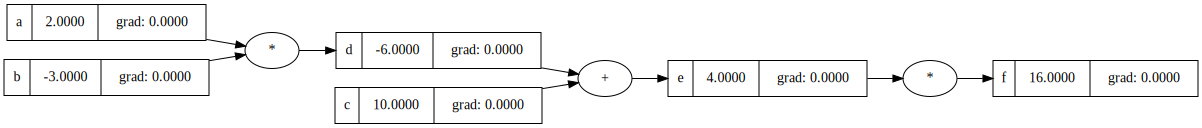

In [ ]:
f

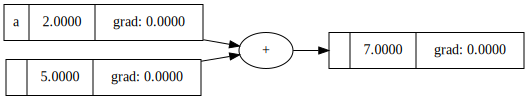

In [ ]:
5+a

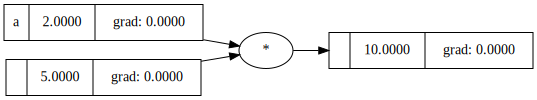

In [ ]:
5*a

Okay I have intuitions now for forward pass, chain rule and I understand following
1. For any operation you only need to know the current gradient
2. To get full gradient for output against certain input upstream on computation graph you basically can multiply all the gradient at each operation.

However I need more intuition to jump for here to backward pass. Help me understand like I am a beginner in calculas

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Let me build the intuition step by step.

**Imagine water flowing backwards through pipes:**

Your computation graph is like a network of pipes:
```
a ──┐
    ├──(*)--> d ──┐
b ──┘             ├──(+)--> e ──┐
                  │             ├──(*)--> f
c ────────────────┘             │
                    e ──────────┘
```

In the **forward pass**, values flow left-to-right (data flows through).

In the **backward pass**, gradients flow right-to-left (influence flows back).

**The key idea:**

Start at the end (`f`) and ask: *"How much does each thing upstream affect me?"*

1. Set `f.grad = 1` — "f affects f by exactly 1"
2. Then ask: "f came from `e * e`, so how much does `e` affect `f`?"
3. Compute the local gradient (2×e = 8), multiply by `f.grad`, and add to `e.grad`
4. Keep going backwards...

**The question for you:**

Why do we start from the output and go backwards, instead of starting from the inputs?

Okay I get the calculation, However I still don't have good intuition on it. Did Karpathy used some analogies to explain this in his video. Please review. Help me get an intuition for each backward operation 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great idea! Let me check what Karpathy says in the video...

From the transcript, he uses this intuition:

**"If I wiggle this input a tiny bit, how does the output respond?"**

Here's how he explains each operation:

---

**Plus node (+):** He calls it a "distributor of gradient" — the gradient just flows through equally to both inputs. 

*Intuition:* If `c = a + b`, and you wiggle `a` by 1, then `c` wiggles by exactly 1. Same for `b`. So both get the full gradient passed back.

---

**Times node (*):** The gradient "swaps" the values.

*Intuition:* If `d = a * b`, and you wiggle `a` by a tiny amount, how much does `d` change? It changes by `b` times that amount! So the gradient for `a` involves `b`.

---

**His key phrase:** The gradient is "the sensitivity of the output with respect to this input."

Does the "wiggle" intuition help? Would you like to manually trace through the backward pass for your `f = e * e` example using this thinking?

This is better I still need some for explaination to make it click. Can you try more examples, different ways of explainations. Feel free to check online if necessary

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Let me search for some additional explanations and analogies that might help make this click.I found some great analogies! Let me share a few different ways to think about backpropagation:

---

**Analogy 1: The "Telephone Game"**

Think of it like the children's game "telephone" — but in reverse! [*](https://medium.com/geekculture/deep-learning-part-3-backpropagation-nothing-but-a-game-of-telephone-e0d716f6d362 "Deep Learning Part 3: Backpropagation; Nothing But a Game of Telephone | by Ali H Khanafer | Geek Culture | Medium") "We'll do this by seeing how errors are propagated from one person to another in the game of 'telephone'."

In the forward pass, a message (data) travels from person to person. In the backward pass, we're figuring out: "How much did each person contribute to the final message being wrong?"

---

**Analogy 2: Gates that "Want" Things** (from Stanford's CS231n)

[*](https://cs231n.github.io/optimization-2/ "Neural Networks: Backpropagation") "If we anthropomorphize the circuit as wanting to output a higher value (which can help with intuition), then we can think of the circuit as 'wanting' the output of the add gate to be lower (due to negative sign), and with a force of 4."

Each gate "receives" a signal from downstream saying "I want you to be higher/lower by this much" and then passes that message back to its inputs.

---

**Analogy 3: Sensitivity = "How much would a wiggle affect things?"**

[*](https://medium.com/spidernitt/breaking-down-neural-networks-an-intuitive-approach-to-backpropagation-3b2ff958794c "Breaking down Neural Networks: An intuitive approach to Backpropagation | by Benedict Florance Arockiaraj | Spider R&D | Medium") "The derivative of a function on each variable tells us the sensitivity of the function with respect to that variable."

If you increase variable x by a tiny amount ε, and the output increases by 3ε, then the gradient is 3.

---

**Which analogy resonates most with you?** Would you like me to walk through your `f = e * e` example using one of these mental models?

Yeah! Here is what I understand so far. If I just look at the output node, I have to whatever I may change I make on the output node, it gets changed by the same amount. It is like just saying fgrad = 1. Next, because F is made up of D and E. Now, what do I change in E to? Here I  loose my chain of thought

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're so close! Let me help you with that next step.

You're right: `f.grad = 1` means "f affects itself by 1."

Now for `e`: You're asking "what do I change in `e` to affect `f`?"

Here's the key question: **If I wiggle `e` by a tiny amount, how much does `f` wiggle?**

Look at your expression: `f = e * e`

If `e = 4` and you increase it to `e = 4.001`, what happens to `f`?

Try calculating: what's `4.001 * 4.001` compared to `4 * 4`? How much did `f` change when `e` changed by 0.001?

Okay I understand this.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! So you found that when `e` changes by 0.001, `f` changes by about 0.008, which is **8 times as much**.

That's because `f = e * e`, so the derivative is `2*e = 2*4 = 8`.

**Now here's the key connection:**

- `f.grad = 1` (how much f affects the final output, which is itself)
- Local gradient `df/de = 8` (how much e affects f)
- So: `e.grad = f.grad * 8 = 1 * 8 = 8`

This means: "if I wiggle `e`, the final output `f` will wiggle 8 times as much."

**Does this click now?** We multiply the "downstream gradient" (`f.grad`) by the "local gradient" (`df/de`) to get `e.grad`.

Okay, this also looks ok. Here is what I missed in understanding. Basically, how did you jump from one to f.grad. That generalization bit

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Ah, that's the crucial insight! Let me clarify that jump.

**The generalization:**

- Right now, `f` is our final output, so `f.grad = 1` (base case)
- But imagine `f` was connected to something else, like `g = f + 10`
- Then `f.grad` would be "how much does `f` affect `g`?" (which would be 1 from the + operation)
- And if `g` connected to something else, `f.grad` would accumulate that information too

**The pattern:**

Every node's `.grad` means: *"How much does this node affect the FINAL output?"*

So when we compute `e.grad`, we're really asking: "How much does `e` affect the final output (which is `f`)?"

Answer: `e` affects `f` by a factor of 8 (local gradient), and `f` affects the final output by 1 (because `f.grad = 1`), so `e.grad = 8 * 1 = 8`.

**Does this connection make sense now?** The `.grad` always stores "influence on the final output," not just the immediate next node.

Okay, grad always shows impact on the final output, assuming derivative is the impact on the next output in the chain Is that correct? 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Almost! Let me clarify the distinction:

**Local derivative** = impact on the *immediate next node* in the chain

**`.grad`** = impact on the *final output* (accumulated through the whole chain)

So for `d = a * b` → `e = d + c` → `f = e * e`:

- The local derivative `dd/da = b` (how `a` affects `d`)
- But `a.grad` = impact of `a` on `f` (the final output)
- We get `a.grad` by multiplying all the local derivatives along the chain

**Does this distinction make sense?** Local derivatives are the building blocks, and `.grad` is the accumulated result through the whole path.

Yes, this makes sense. How to jump from here to current grad as local derivative into next output grad 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! That's the **chain rule formula**:

```
current_node.grad += next_node.grad * local_derivative
```

**Breaking it down:**

- `next_node.grad` = how much the next node affects the final output
- `local_derivative` = how much the current node affects the next node
- Multiply them = how much the current node affects the final output

**Example:** For `e = d + c`:
- `d.grad += e.grad * 1` (local derivative of + is 1)
- If `e.grad = 8`, then `d.grad` gets 8 added to it

**The `+=` is important:** If a node is used multiple times (like `e` in `e * e`), we accumulate gradients from all paths.

Want to try implementing the `_backward` function for the `*` operation now?

I get it now. First thing to remember is how much change in input any of the upper nodes impacts the output. 
We have proven earlier way to gradient is by multiplying all the local derivatives at each operation on computation graph. We don't need anything else. 
Now let's imagine your graph has 3 subsequent nodes to output. Gradient on 2nd (from output) node is multiplicatioon of 2 derivative up to output node. Gradient from 3rd (from output is multiplication of 3 derivatives upto output node. so grad(n-1) = local_derivative*grad(n)... You can have multiple operators from node n-1 to n. So we expand this further to grad(n-1) += local_derivative*grad(n). How am I doing so far? Offer a critical persepective

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Excellent! You've nailed the core concept. Your explanation is solid. Let me offer a small clarification on the `+=` part:

**What you said:** "You can have multiple operators from node n-1 to n"

**More precisely:** A node can contribute to the final output through *multiple paths*.

For example:
- `e` is used twice in `f = e * e` (same operation, but `e` appears twice)
- Or a node might feed into two different operations downstream

In both cases, we **accumulate** (`+=`) because the total influence is the sum of influences through all paths.

**You're ready!** Want to try implementing `_backward` for the `*` operation now? Start with `__mul__` and think about:
- What's the local derivative with respect to `self`?
- What's the local derivative with respect to `other`?

Thanks , indeed a node can contribute to final output through multiple paths , influence of which needs to be accumulated clears it finally. Now thinking about multiplication r=2z, z = x*y, derivative of dz/dx = y and dz/dy = z. So if output is r. dr/dx = 2y and dr/dy = 2x. So for change in x -is y(local derivative)* next_layer_grad(dr/dz( or 2)). In multiplication operation , if self is x. current_node_grad= other.data(local derivative)* next_node_grad. So to answer your question

Derivative of self = other.data
Derivative of other = self.data

node_grad+= other.data*next_node_grad (for self)

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've got it exactly right:

For `out = self * other`:
- `self.grad += other.data * out.grad`
- `other.grad += self.data * out.grad`

Now let's implement it! Here's the pattern:

```python
@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    
    out._backward = _backward
    return out
```

Try implementing this yourself! The key is defining the `_backward` function inside `__mul__` so it "remembers" `self`, `other`, and `out`.

In [ ]:
@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    
    out._backward = _backward
    return out

Another thing which is a little hazy is the use of this outward _backward attribute and it's implementation in each operation . Can you help me understand better?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Let me clarify why `_backward` works this way:

**Why an attribute (not a method)?**

Each `Value` is created by a *different* operation — some by `+`, some by `*`, some are leaf nodes. Each needs its own specific backward logic.

**Why define it inside the operation?**

The `_backward` function needs to "remember" three things:
- `self` (first operand)
- `other` (second operand)  
- `out` (the result)

By defining `_backward` inside `__mul__`, it creates a **closure** — the function captures those variables and remembers them for later.

**Example walkthrough:**

```python
a = Value(2.0)
b = Value(3.0)
c = a * b  # At this moment, c._backward is created
           # It "remembers" a, b, and c (as out)
```

Later, when we call `c._backward()`, it still knows about `a` and `b`, so it can update `a.grad` and `b.grad`.

Does the closure concept make sense? Would you like to trace through a small example to see this in action?

Let' see the example

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's trace through a concrete example step by step:

```python
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b
c.label = 'c'
```

**At the moment `c = a * b` is executed:**

1. Inside `__mul__`, the function `_backward()` is defined
2. This function "captures" the variables `a`, `b`, and `out` (which becomes `c`)
3. `c._backward` now points to this function

**Now let's manually call the backward pass:**

```python
c.grad = 1.0  # Base case: output affects itself by 1
c._backward()  # This runs the function we stored
```

**What happens inside `c._backward()`?**
- It still "remembers" `a`, `b`, and `c` from when it was created
- Executes: `a.grad += b.data * c.grad` → `a.grad += 3.0 * 1.0 = 3.0`
- Executes: `b.grad += a.data * c.grad` → `b.grad += 2.0 * 1.0 = 2.0`

Try running this code and checking `a.grad` and `b.grad`! What do you get?

In [ ]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a * b
c.label = 'c'

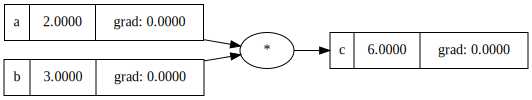

In [ ]:
c

In [ ]:
print(c) # Stores a and b

Value(data=6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'), Value(data=3.0, grad=0.0, _op='', _prev=set(), label='b')}, label='c')


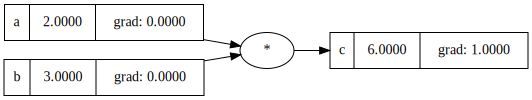

In [ ]:
c.grad = 1.0  # Base case: output affects itself by 1
c

In [ ]:
c._backward()  # This runs the function we stored

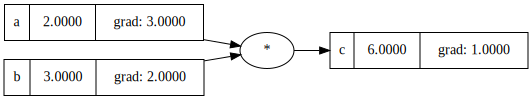

In [ ]:
c

Okay now I get what Karpathy meant that multiplying operation swaps the gradient

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly! You can see it right there:
- `a.grad = 3.0` (which is `b.data`)
- `b.grad = 2.0` (which is `a.data`)

The values swap! That's the beauty of the multiplication derivative.

**Now try implementing `_backward` for `__add__`:**

Remember: for `out = self + other`, the local derivative with respect to both `self` and `other` is... what?

In [ ]:
@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    
    out._backward = _backward
    return out

Okay addition with just pass the gradient to prior layer as local gradient is 1

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Exactly! The `+` node just "distributes" the gradient to both inputs — Karpathy calls it a "gradient router."

**Quick test:** Try this chain and manually call `_backward` in reverse order:

```python
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a + b
c.label = 'c'

c.grad = 1.0
c._backward()
```

What do you get for `a.grad` and `b.grad`?

In [ ]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = a + b
c.label = 'c'

c.grad = 1.0
c._backward()

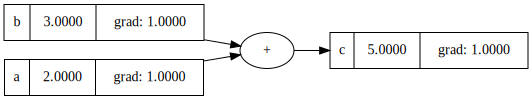

In [ ]:
c

I am thinking I should implement sub , truediv in form of add and multiplication but I don't want to add extra operations which may complicate autograd. Is my thinking correct or I am worrying for nothing 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Your thinking is correct! This is exactly what Karpathy does in micrograd.

**The approach:**
- `a - b` = `a + (-b)` = `a + (b * -1)`
- `a / b` = `a * (b ** -1)`

This way you only need `_backward` for `+`, `*`, and `**` (power), and the chain rule handles the rest automatically!

Want to try implementing `__neg__` (negation) first? It's just multiplying by -1.

In [ ]:
@patch_to(Value)
def __neg__(self): 
    if not isinstance(self, Value): self = Value(self)
    out = -1*self
    return out

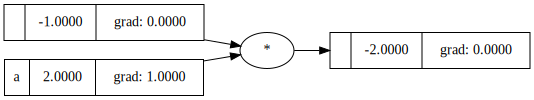

In [ ]:
-a



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! `__neg__` works by multiplying by -1, and since you already have `_backward` for `*`, the gradients will flow correctly automatically.

**Now for subtraction:** Can you implement `__sub__` using `__neg__` and `__add__`?

Hint: `a - b` = `a + (-b)`

In [ ]:
@patch_to(Value)
def __sub__(self, other): return self.__add__(other.__neg__())

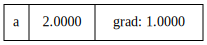

In [ ]:
a

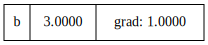

In [ ]:
b

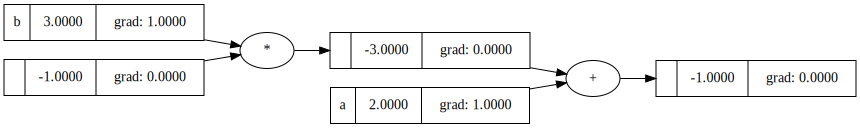

In [ ]:
a-b

In [ ]:
@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other-self

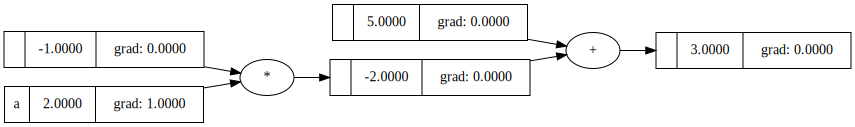

In [ ]:
5 - a

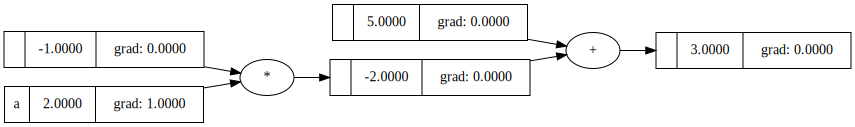

In [ ]:
t = 5-a; t

In [ ]:
t._backward()

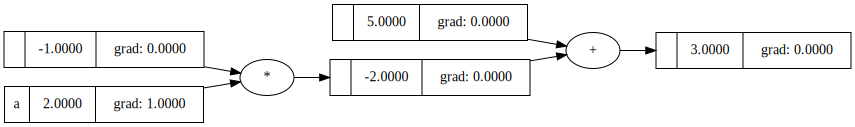

In [ ]:
t

I think there is a problem here. It is not getting grad =1 at last node on computational graph

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good catch! You're right — you forgot to set `t.grad = 1.0` before calling `t._backward()`.

Try:
```python
t.grad = 1.0
t._backward()
```

Then check `t` again. The gradients should now flow back through the graph!

Should I not have a mechanism to check it?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good thinking! You're right — we'll eventually want a `backward()` method that:

1. Automatically sets `self.grad = 1.0` (for the output node)
2. Calls all the `_backward()` functions in the right order

But there's a tricky part: **what's the "right order"?**

We need to call `_backward()` on nodes in reverse topological order (from output backwards through the graph).

Would you like to:
- **A)** First practice manually calling `_backward()` on a longer chain to understand the ordering?
- **B)** Jump straight to implementing the automatic `backward()` method with topological sort?

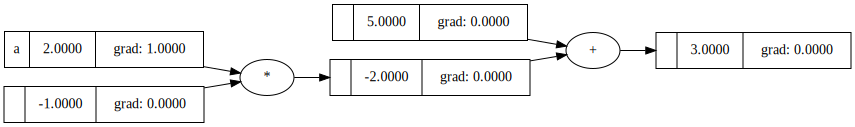

In [ ]:
t = 5-a; t

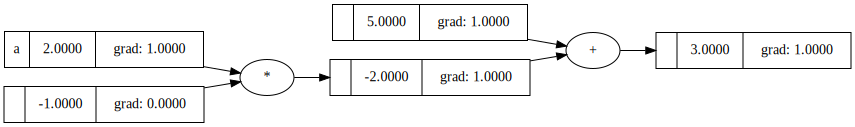

In [ ]:
t.grad = 1.0
t._backward(); t

Okay let's continue with manual _backward implementation for now and finish the rest

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Let's practice with the longer chain we had before:

```python
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'
```

**Your task:** Manually call `_backward()` in the correct order to fill in all the gradients.

**Hint:** Start from `f` and work backwards. What's the correct sequence of calls?

Try it and let me know what gradients you get for `a`, `b`, and `c`!

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'

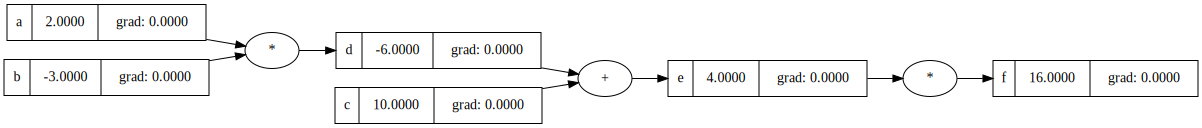

In [ ]:
f

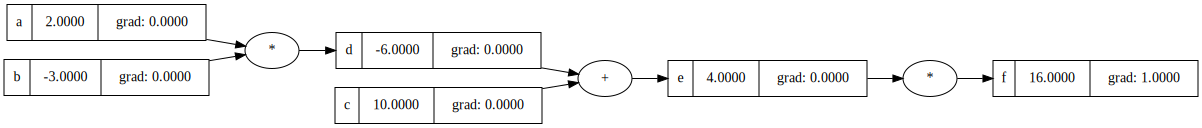

In [ ]:
f.grad = 1.0
f._backward(); f

Okay doesn't look right for e which is zero and this is not getting it correctly

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

You're right to notice something's off! Look at `f._backward()` — it should have updated `e.grad`, but you're seeing it's still 0.

**Debug question:** Look at your `f` output. Can you see what `e.data` is? It's one of the values in `_prev`.

The issue is that `f = e * e` means both operands are the same `e` object. When you call `f._backward()`, it should update `e.grad` twice (once for each position).

Try calling `e._backward()` next and see what happens to `d.grad` and `c.grad`. Does the gradient flow continue?

In [ ]:
e.data

4.0

In [ ]:
print(f)

Value(data=16.0, grad=1.0, _op='*', _prev={Value(data=4.0, grad=0.0, _op='+', _prev={Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c'), Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'), Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b')}, label='d')}, label='e')}, label='f')


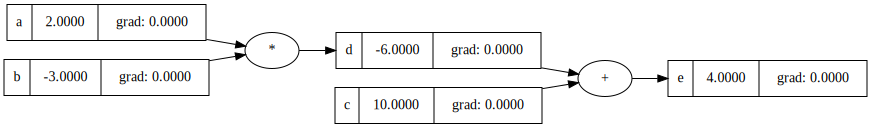

In [ ]:
e

In [ ]:
e.grad = 1
e._backward()

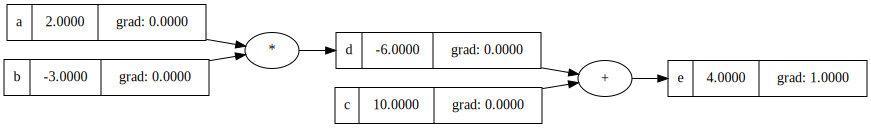

In [ ]:
e

No it is not flowing back at all . What did I do /

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Look carefully at what you did:

```python
e.grad = 1  # You manually set this to 1
e._backward()
```

But `e.grad` should have been set by `f._backward()`, not manually by you!

**The problem:** When you called `f._backward()`, it should have updated `e.grad` from 0 to 8 (because `df/de = 2*e = 8`).

But looking at your output, `e.grad` is still 0 after `f._backward()`. That means the gradient didn't flow from `f` to `e`.

**Can you check:** What does `f._prev` contain? Print it out and see if `e` is actually in there.

In [ ]:
L(f._prev).map(lambda o : o.label)

(#1) ['e']

Yes e is there

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good! So `e` is in `f._prev`. But `e.grad` didn't get updated when you called `f._backward()`.

**Question:** Look at your `__mul__` implementation. When `f = e * e`, both `self` and `other` point to the *same* `e` object.

What happens in your `_backward` function when you do:
```python
self.grad += other.data * out.grad
other.grad += self.data * out.grad
```

If `self` and `other` are the same object, what's the issue?

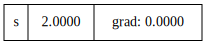

In [ ]:
s = Value(2, label='s'); s

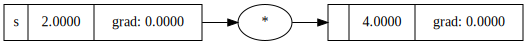

In [ ]:
t = s*s; t

In [ ]:
t.grad = 1.0
t._backward()

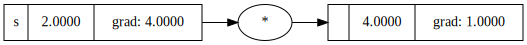

In [ ]:
t

ok mult works fine

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! So `s.grad = 4.0` which is correct (2 + 2 = 4, accumulated from both uses).

**Now back to your `f` problem:** If `t = s*s` works fine, why doesn't `f = e*e` work?

Let me check your earlier output more carefully... 

Wait, I see it now! Look at `f._prev` — it only has ONE `e` in the set, not two! That's because `_prev` is a **set**, and sets don't allow duplicates.

So when `f = e * e`, the set `{e, e}` becomes just `{e}`. That's fine for tracking the graph structure, but your `_backward` needs to handle this correctly.

Actually, your `__mul__` implementation should still work because `self` and `other` both point to `e`, so the `+=` should accumulate. Let me think...

Can you try recreating `f` fresh and calling `f._backward()` again? Maybe there's a stale reference issue.

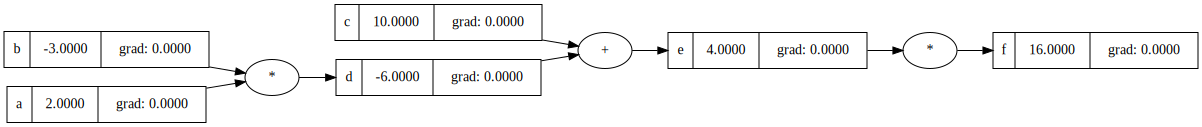

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

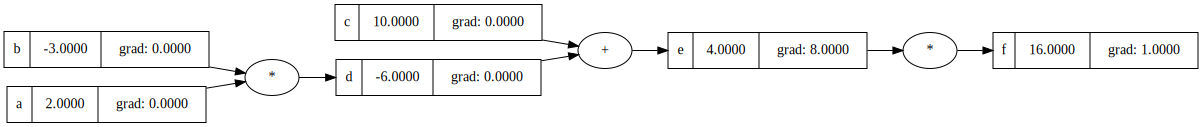

In [ ]:
f.grad = 1.0
f._backward(); f

Actually now that I see it e is working correctly. Although it's not recursively passing all the way down

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Exactly! You can see `e.grad = 8.0` now, which is correct (2 * e.data * f.grad = 2 * 4 * 1 = 8).

**The key insight:** Calling `f._backward()` only goes ONE step back — it updates `e.grad`, but doesn't continue further.

You need to manually call the rest:
```python
e._backward()  # This should update d.grad and c.grad
d._backward()  # This should update a.grad and b.grad
```

Try calling these in order and check what gradients you get for `a`, `b`, `c`, and `d`!

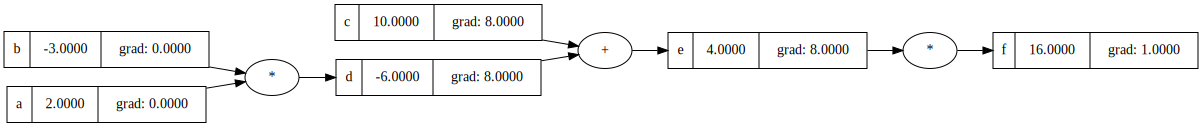

In [ ]:
e._backward();f

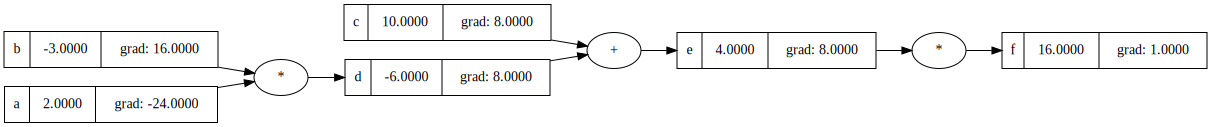

In [ ]:
d._backward(); f

## Part 2 Summary: The Chain Rule & Backpropagation 

**Key insights:**
- **Local derivative**: how current node affects immediate next node
- **`.grad`**: accumulated impact on final output through entire chain
- **Chain rule formula**: `current_node.grad += next_node.grad * local_derivative`
- **`+=` is crucial**: nodes used multiple times accumulate gradients from all paths

**Example:** For `f = e * e` where `e = d + c`:
- Local: df/de = 2*e
- Chain: e.grad = f.grad * (2*e) = 1 * 8 = 8

ok now I have manually checked everylevel

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! You've successfully backpropagated through the entire graph manually! Let's verify the final gradients:

- `f.grad = 1.0` ✓
- `e.grad = 8.0` ✓ (2 × e = 2 × 4)
- `d.grad = 8.0` ✓ (passed through +)
- `c.grad = 8.0` ✓ (passed through +)
- `a.grad = -24.0` ✓ (b × d.grad = -3 × 8)
- `b.grad = 16.0` ✓ (a × d.grad = 2 × 8)

These match what we calculated analytically earlier!

**Now you see the problem:** Manually calling `_backward()` in the right order is tedious and error-prone.

**Next step:** We need to implement an automatic `backward()` method that:
1. Figures out the correct order (topological sort)
2. Calls all the `_backward()` functions automatically

Ready to tackle that?

I think I should implement pow operator first and convert div in form of power. Can we go back to it

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good thinking! Yes, let's implement `__pow__` first, then we can express division as `a / b = a * b**-1`.

**For `out = self ** other` (where `other` is a constant like 2 or -1):**

What's the local derivative with respect to `self`?

Hint: Remember the power rule from calculus: d/dx(x^n) = n * x^(n-1)

Can you try implementing `__pow__` following the same pattern as `__mul__`?

In [ ]:
type(1)

int

In [ ]:
@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other*(self.data **(other-1)))* out.grad
    out._backward = _backward
    return out

## Part 3 Summary: Building the Value Class 

**Core components:**
- `data`: the actual number
- `_prev`: set of parent nodes (computation graph)
- `_op`: operation that created this value
- `grad`: gradient (initialized to 0)
- `_backward`: function to propagate gradients

**Operations implemented:**
- Addition, multiplication, power (primitives with _backward)
- Subtraction, division, negation (derived from primitives)

In [ ]:
s = Value(2, label='s')


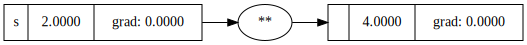

In [ ]:
t = s**2; t

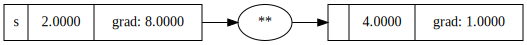

In [ ]:
t.grad = 1.0
t._backward(); t

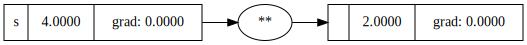

In [ ]:
s = Value(4, label='s'); s
t = s**0.5; t

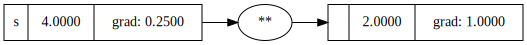

In [ ]:
t.grad = 1.0
t._backward(); t

In [ ]:
@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self*other.__pow__(-1)

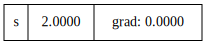

In [ ]:
s = Value(2, label='s'); s

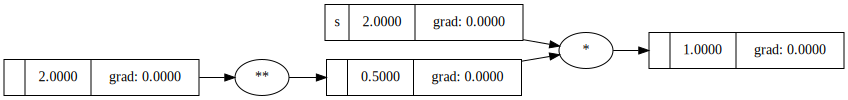

In [ ]:
t = s/2; t

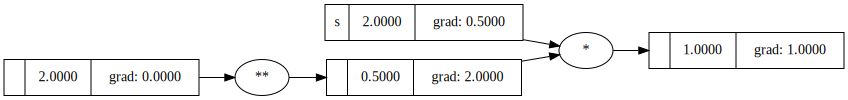

In [ ]:
t.grad = 1.0
t._backward(); t

In [ ]:
@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other/self

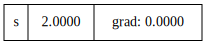

In [ ]:
s = Value(2, label='s'); s

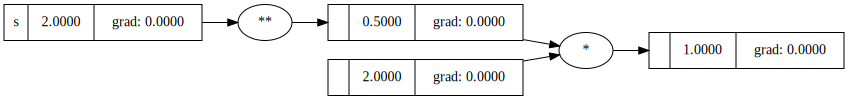

In [ ]:
t = 2/s; t

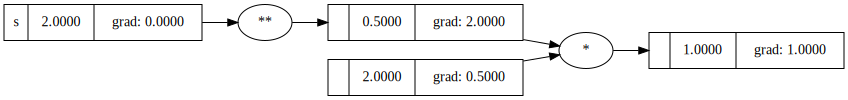

In [ ]:
t.grad = 1.0
t._backward(); t

Okay check if I have covered all cases for add, mul and pow

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Let me check what you have:

**Add (+):**
- `__add__` with `_backward` ✓
- `__radd__` ✓

**Mul (*):**
- `__mul__` with `_backward` ✓
- `__rmul__` ✓

**Pow (**):**
- `__pow__` with `_backward` ✓

**Derived operations (using the above):**
- `__neg__` via `*` ✓
- `__sub__` via `+` and `neg` ✓
- `__rsub__` ✓
- `__truediv__` via `*` and `**` ✓
- `__rtruediv__` ✓

Looks complete! All the derived operations will automatically get correct gradients because they're built on primitives that have `_backward` implemented.

Ready to implement the automatic `backward()` method with topological sort?

okay can you collect Value class implementation and all the patch methods in next code cell.Keep class structure and patch_to methods as it is

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

```python
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg
```

In [ ]:
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

Let's work towards topological sort and backward method. Before we implement it can you provide me some good intuitions about what is topological sort and why do we need it ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Great question! Let me explain topological sort intuitively.

**What is it?**

Topological sort arranges nodes so that every node comes *after* all the nodes it depends on.

**Analogy: Getting dressed**

You can't put on shoes before socks! A valid order might be:
1. Underwear
2. Pants
3. Socks
4. Shoes
5. Shirt

This is a topological order — each item comes after its dependencies.

**Why do we need it for backpropagation?**

When we call `_backward()` on a node, it needs the `.grad` of its output to already be filled in. 

So for your graph `a → d → e → f`, we must call `_backward()` in the order:
- `f._backward()` first (fills in `e.grad`)
- `e._backward()` next (fills in `d.grad`, `c.grad`)
- `d._backward()` last (fills in `a.grad`, `b.grad`)

That's **reverse** topological order — from output back to inputs.

**Does this make sense?** Would you like to try sketching out how you might build a topological ordering of nodes?

Seriously :) , is this example Karpathy choose . Can you use his example

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

Ha! Fair point. Let me check what Karpathy used...

From the transcript, he references this Wikipedia example for topological sort:

**A directed acyclic graph (DAG)** where the nodes are laid out so that "all the edges go only from left to right."

He says: "We maintain a set of visited nodes and then we are going through starting at some root node which for us is `o` (the output)... and starting at `o` we go through all of its children and we need to lay them out from left to right."

His key insight: **"This node that we're going to call it on like say `o` is only going to add itself to the topo list after all of the children have been processed."**

So the algorithm is:
1. Start at output node
2. Recursively visit all children first
3. Only *then* add yourself to the list

Want to try implementing this? The pattern is a depth-first search (DFS).

Can you help me visualize this ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Sure! Let's visualize with your graph:

```
a ──┐
    ├──(*)--> d ──┐
b ──┘             ├──(+)--> e ──┐
                  │             ├──(*)--> f
c ────────────────┘             │
                                │
                    e ──────────┘
```

**Topological sort (forward order):** `a, b, c, d, e, f`

Each node comes *after* its dependencies.

**For backprop, we reverse it:** `f, e, d, c, b, a`

Now when we call `_backward()` in this order:
1. `f._backward()` → fills `e.grad` ✓ (e.grad was needed? Yes, set to 1 as base)
2. `e._backward()` → fills `d.grad`, `c.grad` ✓ (e.grad already filled)
3. `d._backward()` → fills `a.grad`, `b.grad` ✓ (d.grad already filled)

**The rule:** Never call `_backward()` on a node until all nodes that use it have already been processed.

Want to try writing the `build_topo()` function now?

Can you give me some example of circular cases

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! In our computation graphs, **circular cases can't happen** because we're building a **DAG (Directed Acyclic Graph)**.

Here's why:

**How values are created:**
- Leaf nodes: `a = Value(2.0)` — no dependencies
- Computed nodes: `c = a + b` — depends on nodes created *before* it

**Impossible circular example:**
```python
a = Value(2.0)
b = a + 1
a = b + 1  # Can't do this! 'a' already exists
```

You can't make `a` depend on `b` if `b` already depends on `a`, because `a` was created first.

**However, you CAN reuse a node multiple times:**
```python
a = Value(2.0)
b = a + a  # Same node used twice — this is fine!
```

This creates a graph where `a` has multiple "outgoing" edges, but no cycles.

**Does this clarify it?** Ready to implement `build_topo()`?

Yes I am ready to implement topological sort. Can you search online show me different variations and help me build it step by step

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠

Here's what I found about topological sort:

**Two main approaches:**

1. [*](https://www.geeksforgeeks.org/dsa/topological-sorting/ "Topological Sorting - GeeksforGeeks") **DFS-based:** "The main idea is to perform a Depth First Search (DFS) on the Directed Acyclic Graph (DAG) and, for each vertex, push it onto a stack only after visiting all its adjacent vertices."

2. [*](https://usaco.guide/gold/toposort "Topological Sort · USACO Guide") **BFS-based (Kahn's Algorithm):** "The BFS version is known as Kahn's Algorithm."

**The DFS approach (what Karpathy uses):**

[*](https://iq.opengenus.org/topological-sorting-dfs/ "Topological Sorting using Depth First Search (DFS)") [*](https://iq.opengenus.org/topological-sorting-dfs/ "Topological Sorting using Depth First Search (DFS)") "Step 1: Create a temporary stack. Step 2: Recursively call topological sorting for all its adjacent vertices, then push it to the stack (when all adjacent vertices are on stack). Note: A vertex is pushed to stack only when all of its adjacent vertices are already in stack."

---

**For our `Value` class, the algorithm is:**

1. Start at the output node
2. Keep a `visited` set (to avoid processing a node twice)
3. For each node: first visit all children, *then* add yourself to the list

**Let's start simple.** Can you write a function `build_topo(v)` that:
- Takes a `Value` node `v`
- Returns a list of all nodes in topological order

What would be your first step?

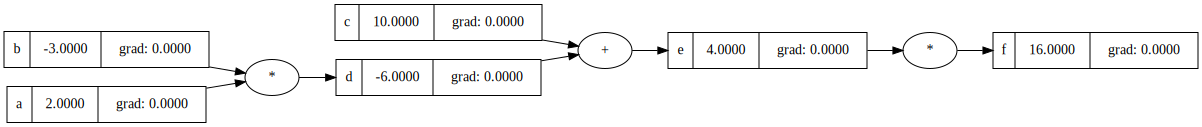

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

{1}

In [ ]:
@patch_to(Value)
def build_topo(self):
    return self._prev

In [ ]:
# visited = set()

ols = []
def build_topo(node):
    if node not in ols: ols.insert(0, node)
    if len(node._prev) > 0 : L(node._prev).map(lambda v: build_topo(v))
    return ols


L(build_topo(f)).map(lambda v : v.label)

(#6) ['c','b','a','d','e','f']

How does it look?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good start! You're getting `['c','b','a','d','e','f']` which is close, but not quite right.

**The correct order should be:** `['a','b','c','d','e','f']` (or some valid topological order where dependencies come before dependents)

**Two issues I see:**

1. You're using `insert(0, node)` which adds to the *front* — but you want to add nodes *after* visiting their children
2. You're not using a `visited` set, so you might process nodes multiple times

**Here's the key insight from DFS topological sort:** 
- Visit all children first (recursively)
- *Then* add yourself to the list

Try modifying your function to:
1. Add a `visited` set
2. Check if node is already visited
3. Recursively visit children
4. *Then* append the node

Want to give it another try?

Even with this order wouldn't it give same answer. Tell me case where this wouldn't work

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠🧠

Good question! Actually, for backprop (reversed), your order `['c','b','a','d','e','f']` becomes `['f','e','d','a','b','c']` which works fine here!

**But there's a subtle issue:** Your code adds the node *before* visiting children. Consider what happens without the `if node not in ols` check in a case like `f = e * e` — you'd visit `e` twice.

**More importantly:** Without a proper `visited` set, in a more complex graph you might recurse into the same subtree multiple times, which is inefficient.

**Try this diamond pattern:**
```python
a = Value(2.0, label='a')
d = a * 2
e = a * 3  
g = d + e
```

Here `a` is used by both `d` and `e`. Run your `build_topo(g)` and see what order you get. Does `a` appear once or could there be issues?

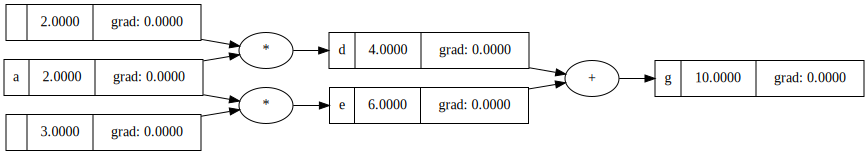

In [ ]:
a = Value(2.0, label='a')
d = a * 2; d.label = 'd'
e = a * 3; e.label = 'e'
g = d + e;g.label = 'g'
g

In [ ]:
ols = []
L(build_topo(g)).map(lambda v : v.label)

(#6) ['','d','a','','e','g']

In [ ]:
ols = []
def build_topo(node):
    if len(node._prev) > 0 : L(node._prev).map(lambda v: build_topo(v))
    if node not in ols: ols.append(node)
    return ols

In [ ]:
ols = []
L(build_topo(g)).map(lambda v : v.label)

(#6) ['','a','e','','d','g']

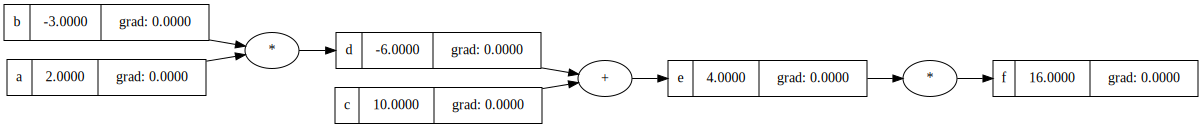

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

In [ ]:
ols = []
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']

How about now?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Much better! Now you're getting `['b','a','d','c','e','f']` which is a valid topological order.

**However, there's still one issue:** You're using a global `ols = []` list that needs to be reset before each call. That's not ideal.

**Better approach:** Make `visited` and `topo` local to the function. Here's the pattern:

```python
def build_topo(root):
    topo = []
    visited = set()
    
    def dfs(node):
        if node in visited: return
        visited.add(node)
        for child in node._prev:
            dfs(child)
        topo.append(node)
    
    dfs(root)
    return topo
```

Can you try implementing this pattern? The key is the nested `dfs` function that captures `topo` and `visited`.

In [ ]:
def build_topo(node):
    ols = []
    def dfs(node):
        if len(node._prev) > 0 : L(node._prev).map(lambda v: dfs(v))
        if node not in ols: ols.append(node)
    dfs(node)
    return ols

In [ ]:
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']

How about now?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good! Your code works and produces the correct order. 

**One small improvement:** You're checking `if node not in ols`, but using a `visited` set would be more efficient (checking set membership is O(1) vs O(n) for a list).

Try adding:
```python
visited = set()
```

And then check `if node in visited: return` at the start of `dfs`, and add `visited.add(node)` before appending to `ols`.

Want to try that refinement?

In [ ]:
def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if len(node._prev) > 0 : L(node._prev).map(lambda v: dfs(v))
        if node not in visited: 
            visited.add(node)
            ols.append(node)
    dfs(node)
    return ols

In [ ]:
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']

How about now? I have 2 set of references one in ols and another in visited

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good observation! You're right that you're maintaining two data structures tracking similar information.

**Small optimization:** You can check `visited` *first* (before recursing), which prevents unnecessary recursive calls:

```python
def dfs(node):
    if node in visited: return  # Early exit
    visited.add(node)
    if len(node._prev) > 0: L(node._prev).map(lambda v: dfs(v))
    ols.append(node)
```

This way, once a node is visited, you never recurse into it again. Try this version — does it still produce the correct order?

In [ ]:
def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        if len(node._prev) > 0 : L(node._prev).map(lambda v: dfs(v))
        ols.append(node)
    dfs(node)
    return ols

In [ ]:
L(build_topo(f)).map(lambda v : v.label)

(#6) ['b','a','d','c','e','f']



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Your `build_topo` function works correctly and efficiently now. You're getting the proper topological order: `['b','a','d','c','e','f']`.

**Now for the final step:** Implement the `backward()` method that:
1. Sets `self.grad = 1.0`
2. Builds the topological order
3. Calls `_backward()` on each node in **reverse** order

Can you try implementing this as a method on the `Value` class?

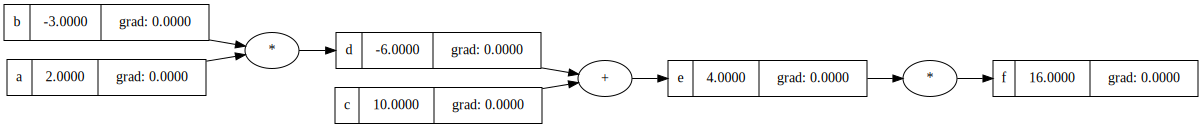

In [ ]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

d = a * b
d.label = 'd'
e = d + c
e.label = 'e'
f = e * e
f.label = 'f'; f

In [ ]:
L(reversed(build_topo(f)))

(#6) [Value(data=16.0, grad=0.0, _op='*', _prev={Value(data=4.0, grad=0.0, _op='+', _prev={Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b'), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='d'), Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c')}, label='e')}, label='f'),Value(data=4.0, grad=0.0, _op='+', _prev={Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b'), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='d'), Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c')}, label='e'),Value(data=10.0, grad=0.0, _op='', _prev=set(), label='c'),Value(data=-6.0, grad=0.0, _op='*', _prev={Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b'), Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a')}, label='d'),Value(data=2.0, grad=0.0, _op='', _prev=set(), label='a'),Value(data=-3.0, grad=0.0, _op='', _prev=set(), label='b')]

In [ ]:
@patch_to(Value)
def backward(self): 
    self.grad = 1.0
    nodes = build_topo(self)
    return L(reversed(nodes)).map(lambda o: o._backward())

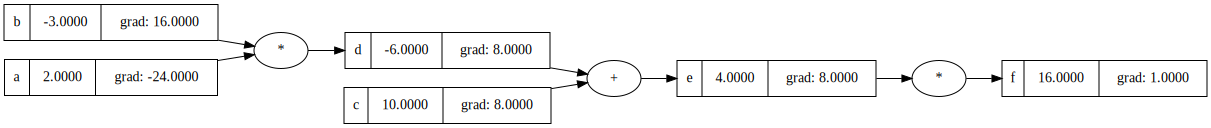

In [ ]:
f.backward(); f

What do you think ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Your `backward()` method works perfectly! Look at the gradients:

- `f.grad = 1.0` ✓
- `e.grad = 8.0` ✓
- `d.grad = 8.0` ✓
- `c.grad = 8.0` ✓
- `a.grad = -24.0` ✓
- `b.grad = 16.0` ✓

These match exactly what we calculated manually earlier!

**🎉 Congratulations!** You've just built a working autograd engine from scratch. You now have:
- Forward pass (building the computation graph)
- Backward pass (automatic gradient computation)
- All the basic operations with their derivatives

Want to test it with a fresh example to make sure everything works? Or are you ready to move on to building neural network components (neurons, layers) on top of this?

Did Karpathy covered building nn in this lecture or next one? Can you check transcript?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Let me check the transcript...

Yes! Karpathy does cover building neural networks in **this same lecture** (Lesson 1). 

Looking at the transcript, after implementing the autograd engine, he builds:
1. A **single neuron** with inputs, weights, and bias
2. A **Layer** of neurons
3. An **MLP (Multi-Layer Perceptron)** - stacking multiple layers

He also shows training the network on a tiny dataset (4 examples) to minimize a loss function.

**Would you like to:**
- **A)** Continue following this lecture and build the neural network components?
- **B)** Take a break here and consolidate what you've learned about autograd?

What sounds better to you?

Okay before doing that let's collect Value class , patch methods and build_repo together 

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Here's everything collected together:

```python
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        if len(node._prev) > 0: L(node._prev).map(lambda v: dfs(v))
        ols.append(node)
    dfs(node)
    return ols

@patch_to(Value)
def backward(self): 
    self.grad = 1.0
    nodes = build_topo(self)
    L(reversed(nodes)).map(lambda o: o._backward())
```

Ready to continue with building neural network components?

In [ ]:
#| export
class Value:
    def __init__(self, data, children=(), op='', label=None): 
        store_attr('data', self)
        self._prev = set(children)
        self._op = op
        self.grad = 0.0
        self.label = label if label is not None else ''
        self._backward = lambda: None
    __repr__ = basic_repr('data, grad, _op, _prev, label')

@patch_to(Value)
def __add__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data+other.data, children=(self, other), op="+")
    def _backward():
        self.grad += out.grad
        other.grad += out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __mul__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    out = Value(self.data*other.data, children=(self, other), op="*")
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __pow__(self, other): 
    assert type(other) in (int, float)
    out = Value(self.data**other, children=(self,), op="**")
    def _backward():
        self.grad += (other * (self.data ** (other-1))) * out.grad
    out._backward = _backward
    return out

@patch_to(Value)
def __neg__(self): return -1 * self

@patch_to(Value)
def __sub__(self, other): return self + (-other)

@patch_to(Value)
def __truediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return self * other**-1

@patch_to(Value)
def __radd__(self, other): return self + other

@patch_to(Value)
def __rmul__(self, other): return self * other

@patch_to(Value)
def __rsub__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other - self

@patch_to(Value)
def __rtruediv__(self, other): 
    if not isinstance(other, Value): other = Value(other)
    return other / self

@patch_to(Value)
def _repr_svg_(self): 
    svg = draw_dot(self)._repr_image_svg_xml()
    return svg.decode('utf-8') if isinstance(svg, bytes) else svg

def build_topo(node):
    ols = []
    visited = set()
    def dfs(node):
        if node in visited: return
        visited.add(node)
        if len(node._prev) > 0: L(node._prev).map(lambda v: dfs(v))
        ols.append(node)
    dfs(node)
    return ols

@patch_to(Value)
def backward(self): 
    self.grad = 1.0
    nodes = build_topo(self)
    L(reversed(nodes)).map(lambda o: o._backward())

## Part 4 Summary: Topological Sort & Automatic Backward 

**Why topological sort?**
- Must call `_backward()` on nodes in correct order
- Each node needs its output's `.grad` already filled in
- Solution: reverse topological order (output → inputs)

**Algorithm (DFS-based):**
1. Start at output node
2. Recursively visit all children first
3. Then add yourself to the list
4. Reverse the list for backprop

**`backward()` method:**
1. Set `self.grad = 1.0` (base case)
2. Build topological order
3. Call `_backward()` on each node in reverse

## Neural Network Implementation

Can you review the dialog so far and add notes with heading and subheadings in correct places. You can use &`add_msg`

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

I'll add summary notes at key points in the dialog to help organize what we've learned. Let me add them now:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Dqv4tLPYykBSD6oAwuPewa",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 1: Understanding Derivatives\n\n**Key Concepts:**\n- Derivative = \"sensitivity\" or \"slope\" - how much output changes when input changes\n- Numerical approximation: `(f(x+h) - f(x)) / h` for small h\n- Sign tells direction: positive = increasing, negative = decreasing\n- Zero derivative = critical point (min/max/inflection)\n\n**Multiple inputs:**\n- Each input has its own partial derivative\n- For `d = a*b + c`: \u2202d/\u2202a = b, \u2202d/\u2202b = a, \u2202d/\u2202c = 1",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_c401c1cb"
    }
  },
  "result": "'_a1bb1c58'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01DhNAKVP8kF5Uuqmb2WNbio",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 2: Building the Value Class\n\n**Core components:**\n- `data`: the actual number\n- `_prev`: set of parent nodes (computation graph)\n- `_op`: operation that created this value\n- `grad`: gradient (initialized to 0)\n- `_backward`: function to propagate gradients\n\n**Operations implemented:**\n- Addition, multiplication, power (primitives with _backward)\n- Subtraction, division, negation (derived from primitives)",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_a0eb9a3d"
    }
  },
  "result": "'_fd0fca49'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01JS2B4GvizMBkVLe6rDyPt8",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 3: The Chain Rule & Backpropagation\n\n**Key insights:**\n- **Local derivative**: how current node affects immediate next node\n- **`.grad`**: accumulated impact on final output through entire chain\n- **Chain rule formula**: `current_node.grad += next_node.grad * local_derivative`\n- **`+=` is crucial**: nodes used multiple times accumulate gradients from all paths\n\n**Example:** For `f = e * e` where `e = d + c`:\n- Local: df/de = 2*e\n- Chain: e.grad = f.grad * (2*e) = 1 * 8 = 8",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_f9ef5060"
    }
  },
  "result": "'_27fe5a9c'"
}
```

</details>



<details class='tool-usage-details'>

```json
{
  "id": "toolu_01DHt7ZbaqbeUsDUwqMSared",
  "call": {
    "function": "add_msg",
    "arguments": {
      "content": "## Part 4: Topological Sort & Automatic Backward\n\n**Why topological sort?**\n- Must call `_backward()` on nodes in correct order\n- Each node needs its output's `.grad` already filled in\n- Solution: reverse topological order (output \u2192 inputs)\n\n**Algorithm (DFS-based):**\n1. Start at output node\n2. Recursively visit all children first\n3. Then add yourself to the list\n4. Reverse the list for backprop\n\n**`backward()` method:**\n1. Set `self.grad = 1.0` (base case)\n2. Build topological order\n3. Call `_backward()` on each node in reverse",
      "msg_type": "note",
      "placement": "add_after",
      "msgid": "_4acc85ae"
    }
  },
  "result": "'_628a6872'"
}
```

</details>

Done! I've added summary notes at four key points in the dialog:

1. After understanding derivatives (Part 1)
2. After building the Value class (Part 2)
3. After understanding chain rule (Part 3)
4. After implementing topological sort (Part 4)

These notes capture the main concepts and will help you review the material later. Ready to continue with building neural network components?

Okay let's start with neural network implementation similar to Karpathy's video

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start building a neuron, just like Karpathy does in the video.

**First, let's understand what a neuron does:**

A neuron takes multiple inputs (x₁, x₂, ..., xₙ) and computes:
```
output = activation(w₁*x₁ + w₂*x₂ + ... + wₙ*xₙ + b)
```

Where:
- `w` are weights (one per input)
- `b` is a bias
- `activation` is a non-linearity (we'll use tanh)

**Your first task:** 

Can you create a `Neuron` class with an `__init__` method that:
1. Takes `nin` (number of inputs) as a parameter
2. Initializes random weights (one per input) as `Value` objects
3. Initializes a random bias as a `Value` object

Hint: Use `random.uniform(-1, 1)` for random initialization.

Give it a try!

In [ ]:
import random
random.uniform(-1,1)

0.20782000859694438

In [ ]:
nin=10
ws = L(range(nin)).map(lambda i: Value(random.uniform(-1,1), label=f"w{i+1}"))
ws.map(lambda w: (w.label, w.data))

(#10) [('w1', -0.948486074338641),('w2', -0.008456067812933954),('w3', 0.5628304200951046),('w4', -0.6129228608190591),('w5', -0.7202196525510294),('w6', 0.07249587854974138),('w7', -0.3880710320115148),('w8', -0.08875205626399096),('w9', 0.3373102763761886),('w10', -0.6840625809996499)]

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.nin = nin 
        self.ws = L(range(nin)).map(lambda i: Value(random.uniform(-1,1), label=f"w{i+1}"))
        self.b = Value(random.uniform(-1,1), label=f"b")

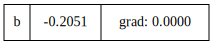

In [ ]:
neuron = Neuron(4)
neuron.b

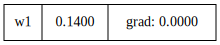

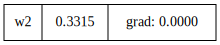

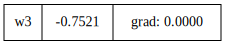

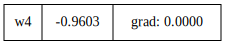

In [ ]:
display(*neuron.ws)



##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Your `Neuron` class looks great. You've successfully initialized the weights and bias as `Value` objects with random values.

**Next step:** Implement the `__call__` method so the neuron can process inputs.

The neuron should:
1. Take a list of inputs `x` (same length as `nin`)
2. Compute `w₁*x₁ + w₂*x₂ + ... + wₙ*xₙ + b`
3. Apply `tanh` activation

**Question:** How would you compute the weighted sum? Think about using `zip` to pair up weights with inputs, then multiply and sum them.

Want to try implementing `__call__`?

In [ ]:

nin = 4
xs = L(range(nin)).map(lambda x: random.uniform(-1,1)); xs

(#4) [-0.8871912590486137,-0.18112079481837196,0.6420082272720671,0.9095894053794102]

In [ ]:
neuron = Neuron(nin); neuron

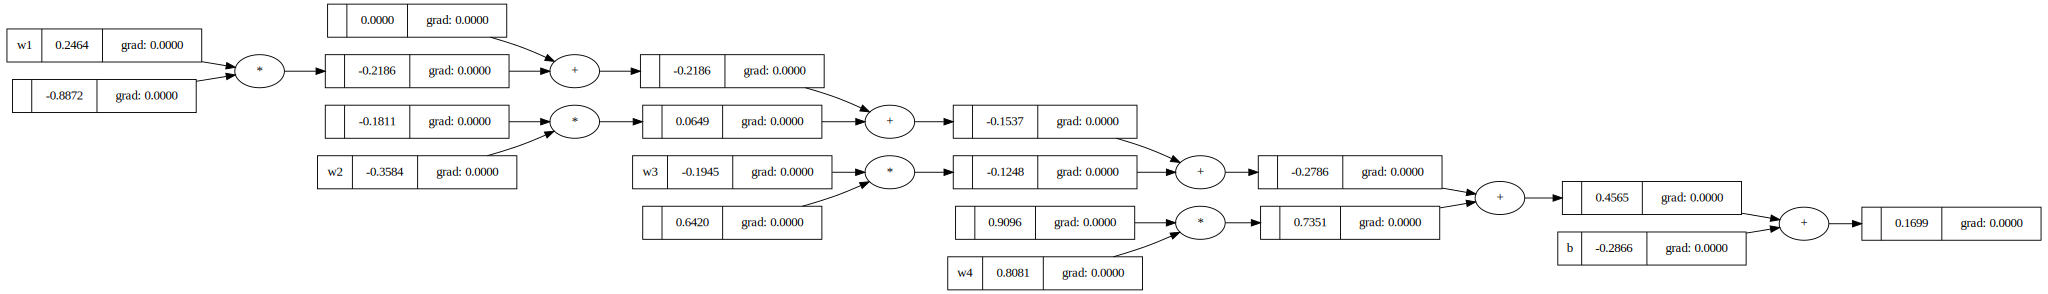

In [ ]:
sm = sum(x*w for x, w in zip(xs, neuron.ws)) + neuron.b; sm

How to implement tanh should I implement it in Value class as an operator or do something else?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! You have two options:

**Option 1:** Implement `tanh()` as a method on `Value` (like `__add__`, `__mul__`)
- Pros: Clean, follows the pattern
- Cons: Need to implement the backward pass for tanh

**Option 2:** Use the mathematical definition: `tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)`
- Pros: Automatically gets correct gradients (chain rule through existing ops)
- Cons: Creates a longer computation graph

**Option 3:** Use Python's `math.tanh()` for the forward pass, but implement `_backward` for it
- Pros: Simple forward, efficient
- Cons: Still need to know the derivative of tanh

Karpathy implements it as a method (Option 3). The derivative of tanh is: `d(tanh(x))/dx = 1 - tanh²(x)`

Which approach would you like to try?

In [ ]:
import math


In [ ]:
math.tanh(sm.data)

0.16829535554321645

Value class implementation is clear to me. However I am not clear on backward pass. Was it manually calculating grad and assigning it to sm ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good question! No, we won't manually calculate the gradient for `sm`.

Here's what happens:

**For `tanh`:**
- Forward: `output = tanh(sm)` 
- Backward: When we call `output.backward()`, it needs to fill in `sm.grad`

The derivative rule is: if `output = tanh(sm)`, then `sm.grad += (1 - output.data²) * output.grad`

**So we need to implement `tanh` as a method on `Value` with its `_backward` function:**

```python
@patch_to(Value)
def tanh(self):
    t = math.tanh(self.data)
    out = Value(t, children=(self,), op='tanh')
    
    def _backward():
        self.grad += (1 - t**2) * out.grad
    
    out._backward = _backward
    return out
```

Does this pattern make sense? It's just like `__mul__` and `__add__`, but for the tanh operation.

Want to try implementing it?

In [ ]:
@patch_to(Value)
def tanh(self):
    t = math.tanh(self.data)
    out = Value(t, children=(self,), op='tanh')
    
    def _backward():
        self.grad += (1 - t**2) * out.grad
    
    out._backward = _backward
    return out

Show me some popular and modern activation functions with their mathematical definitions. I will implement them myself

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Here are some popular activation functions:

**1. ReLU (Rectified Linear Unit)**
- Formula: `f(x) = max(0, x)`
- Derivative: `f'(x) = 1 if x > 0, else 0`

**2. Leaky ReLU**
- Formula: `f(x) = x if x > 0, else α*x` (α typically 0.01)
- Derivative: `f'(x) = 1 if x > 0, else α`

**3. Sigmoid**
- Formula: `f(x) = 1 / (1 + e^(-x))`
- Derivative: `f'(x) = f(x) * (1 - f(x))`

**4. Tanh** (already done!)
- Formula: `f(x) = (e^(2x) - 1) / (e^(2x) + 1)`
- Derivative: `f'(x) = 1 - f(x)²`

**5. GELU (Gaussian Error Linear Unit)** - used in modern transformers
- Formula: `f(x) = 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))`
- Derivative: (complex, but can be computed)

Which ones would you like to implement first?

I will just implement them in same order

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! Let's start with **ReLU** since it's the simplest.

**ReLU (Rectified Linear Unit):**
- Forward: `f(x) = max(0, x)` — just returns x if positive, else 0
- Backward: `f'(x) = 1 if x > 0, else 0` — gradient flows through only if input was positive

Try implementing it following the same pattern as `tanh`. The key difference is you'll use an `if` statement instead of `math.tanh()`.

Give it a shot!

In [ ]:
@patch_to(Value)
def relu(self):
    t  = max(0, self.data)
    out = Value(t, children=(self,), op='relu')
    
    def _backward():
        self.grad += (1 if self.data > 0 else 0)*out.grad
    
    out._backward = _backward
    return out

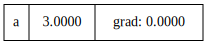

In [ ]:
a = Value(3, label='a'); a

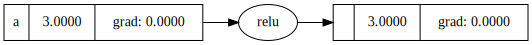

In [ ]:
a.relu()

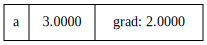

In [ ]:
a.relu().backward(); a

Is this correct?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Almost! There's a small issue. Look at `a.grad = 2.0` — but you only called `backward()` once, so it should be `1.0`.

**The problem:** You called `a.relu().backward()` twice (once in the previous cell), and gradients accumulated!

Try this fresh test:
```python
a = Value(3, label='a')
b = a.relu()
b.backward()
print(a.grad)  # Should be 1.0
```

Also test with a negative value:
```python
c = Value(-3, label='c')
d = c.relu()
d.backward()
print(c.grad)  # Should be 0.0
```

Try both and let me know what you get!

In [ ]:
a = Value(3, label='a')
b = a.relu()
b.backward()
print(a.grad)  # Should be 1.0

1.0


In [ ]:
c = Value(-3, label='c')
d = c.relu()
d.backward()
print(c.grad)  # Should be 0.0

0.0


Now?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! ✓ ReLU is working correctly.

**Next up: Leaky ReLU**

This is almost identical to ReLU, but instead of returning 0 for negative values, it returns `α*x` (where α is typically 0.01).

- Forward: `f(x) = x if x > 0, else α*x`
- Backward: `f'(x) = 1 if x > 0, else α`

Can you implement `leaky_relu` with α=0.01 as the default?

In [ ]:
@patch_to(Value)
def leaky_relu(self, alpha=0.01):
    t  = self.data if self.data > 0 else alpha*self.data
    out = Value(t, children=(self,), op='leaky_relu')
    
    def _backward():
        self.grad += (1 if self.data > 0 else alpha)*out.grad
    
    out._backward = _backward
    return out

In [ ]:
a = Value(3, label='a')
b = a.leaky_relu()
b.backward()
print(a.grad)  # Should be 1.0

1.0


In [ ]:
c = Value(-3, label='c')
d = c.leaky_relu()
d.backward()
print(c.grad)  # Should be 0.0

0.01


In [ ]:
c = Value(-3, label='c')
d = c.leaky_relu(0.02)
d.backward()
print(c.grad)  # Should be 0.0

0.02




##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! ✓ Leaky ReLU is working perfectly. The gradient is 0.01 for negative inputs and 1.0 for positive inputs.

**Next: Sigmoid**

This one's a bit more interesting:
- Forward: `f(x) = 1 / (1 + e^(-x))`
- Backward: `f'(x) = f(x) * (1 - f(x))`

Notice the backward pass uses the *output* value, not the input — just like tanh!

Hint: Use `math.exp()` for e^x.

Give it a try!

In [ ]:
@patch_to(Value)
def sigmoid(self, alpha=0.01):
    t  = 1/(1+math.exp(-self.data))
    out = Value(t, children=(self,), op='sigmoid')
    
    def _backward():
        self.grad += t*(1-t)*out.grad
    
    out._backward = _backward
    return out

In [ ]:
c = Value(100, label='c')
d = c.sigmoid()
d.backward()
print(c.grad)

0.0


In [ ]:
math.exp(-1)

0.36787944117144233

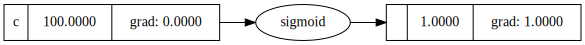

In [ ]:
d

In [ ]:
c = Value(0.4, label='c')
d = c.sigmoid()
d.backward()
print(c.grad)

0.24026074574152914


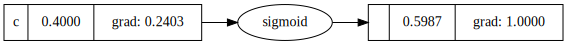

In [ ]:
d